In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
#import keras_tuner as kt
df = pd.read_csv("drive/MyDrive/Engineer's Project/output_eur_pln.csv")

In [ ]:
df.pop('Date')

0       2010.11.15
1       2010.11.16
2       2010.11.17
3       2010.11.18
4       2010.11.19
           ...    
3537    2022.03.27
3538    2022.03.28
3539    2022.03.29
3540    2022.03.30
3541    2022.03.31
Name: Date, Length: 3542, dtype: object

In [ ]:
df

,Opening,High,Low,Closing,Momentum,Range,ohlc
0,3.946604,3.94800,3.94200,3.946765,-0.000162,0.00600,3.945842
1,3.933658,3.96000,3.92190,3.933636,0.000022,0.03810,3.937298
2,3.944550,3.96870,3.92360,3.944601,-0.000050,0.04510,3.945363
3,3.956745,3.96910,3.94680,3.956761,-0.000016,0.02230,3.957352
4,3.938204,3.95420,3.92750,3.938189,0.000015,0.02670,3.939523
...,...,...,...,...,...,...,...
3537,4.727502,4.76989,4.66638,4.727398,0.000104,0.10351,4.722792
3538,4.688071,4.69414,4.68372,4.688092,-0.000021,0.01042,4.688506
3539,4.698296,4.73656,4.68081,4.698331,-0.000035,0.05575,4.703499
3540,4.665875,4.71481,4.63132,4.665837,0.000039,0.08349,4.669461


In [ ]:
scaler = MinMaxScaler()
df_numpy = df.to_numpy() 
scaler = scaler.fit(df_numpy[:3000])
df_scalled = scaler.transform(df_numpy)
df_scalled = pd.DataFrame(df_scalled, columns=[
  'Opening', 'High', 'Low', 'Closing','Momentum', 'Range', 'ohlc'])

In [ ]:
df_train = df_scalled[0:2500]
df_val = df_scalled[2500:3000] #300
df_game = df_scalled[3001:]

In [ ]:
len(df_val)

500

In [ ]:
lookback = 15 #15
step = 1
delay = 0 #0
batch_size = 128

In [ ]:
float_data = np.array(df_scalled).astype('float32')
float_train_data = np.array(df_train).astype('float32')
float_val_data = np.array(df_val).astype('float32')
float_game_data = np.array(df_game).astype('float32')

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=1):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(
        min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][3] 
    yield samples, targets

In [ ]:
train_gen = generator(float_train_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=2499 -delay,
#shuffle=True,
step=step,
batch_size=batch_size)

In [ ]:
val_gen = generator(float_val_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=500-delay ,
step=step,
batch_size=batch_size)

In [ ]:
test_gen = generator(float_game_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=540 -delay,
step=step,
batch_size=batch_size)

In [ ]:
train_steps = (2500 - lookback)
val_steps = (500 - lookback)
test_steps = (541 - lookback)

In [ ]:
del model

NameError: ignored

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.LSTM(120,
  activation='sigmoid',
  input_shape=(None, float_train_data.shape[-1])))
model.add(layers.Dense(160,
  activation='sigmoid',))
model.add(layers.Dense(1,
  activation='sigmoid'))
model.compile(optimizer= tf.keras.optimizers.RMSprop(0.01), loss='mae')
history = model.fit(train_gen,
  steps_per_epoch=100,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
100/100 [==============================] - 15s 123ms/step - loss: 0.3016 - val_loss: 0.0564
Epoch 2/200
100/100 [==============================] - 12s 119ms/step - loss: 0.0991 - val_loss: 0.1294
Epoch 3/200
100/100 [==============================] - 12s 119ms/step - loss: 0.0684 - val_loss: 0.0817
Epoch 4/200
100/100 [==============================] - 12s 121ms/step - loss: 0.0607 - val_loss: 0.0100
Epoch 5/200
100/100 [==============================] - 12s 122ms/step - loss: 0.0526 - val_loss: 0.0166
Epoch 6/200
100/100 [==============================] - 12s 118ms/step - loss: 0.0461 - val_loss: 0.0404
Epoch 7/200
100/100 [==============================] - 12s 119ms/step - loss: 0.0436 - val_loss: 0.0273
Epoch 8/200
100/100 [==============================] - 12s 123ms/step - loss: 0.0406 - val_loss: 0.0592
Epoch 9/200
100/100 [==============================] - 12s 119ms/step - loss: 0.0364 - val_loss: 0.0512
Epoch 10/200
100/100 [==============================] - 14s 139m

In [ ]:
eval = model.evaluate(test_gen, steps = test_steps)

526/526 [==============================] - 10s 19ms/step - loss: 0.0501


In [ ]:
model.save("drive/MyDrive/Engineer's Project/standard_lstm_eur_pln.h5")

In [ ]:
model = tf.keras.models.load_model("drive/MyDrive/Engineer's Project/Final Models/longer_lstm_eur_pln.h5")

In [ ]:
correct_peaks = 0
value = 0
predicted_values = []
actual_values = []
for i in range(0, 541):
  last15 = float_train_data[-lookback:]
  last15 = last15.reshape(1,15,7)
  prediction = model.predict(last15)
  predicted_values.append(prediction[0][0])
  last_val = last15[0][lookback-1][3]
  actual_val = float_game_data[0][3]
  actual_values.append(actual_val)
  if((prediction > last_val) and (actual_val > last_val)):
    correct_peaks+=1
    value +=  100 *(actual_val - last_val)
  elif((prediction < last_val) and (actual_val < last_val)):
    correct_peaks+=1
    value += 100 * (last_val - actual_val)
  else:
    value -= 100 * abs(actual_val - last_val)
  float_train_data = np.vstack((float_train_data, float_game_data[0]))
  float_game_data = np.delete(float_game_data, 0, 0)

1/1 [==============================] - 0s 22ms/step


In [ ]:
scaled_predicted = []
scaled_actual = []
for val in predicted_values:
  val_ = val - scaler.min_[3]
  val_ /= scaler.scale_[3]
  scaled_predicted.append(val_)

for val in actual_values:
  val_ = val - scaler.min_[3]
  val_ /= scaler.scale_[3]
  scaled_actual.append(val_)

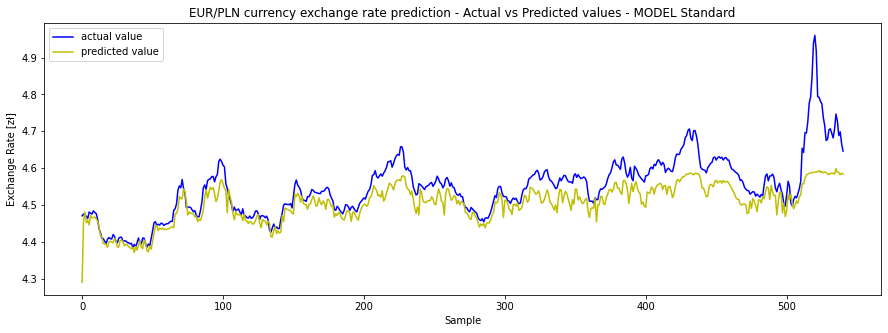

In [ ]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
ax = plt.gca()
plt.xlabel("Sample")
plt.ylabel("Exchange Rate [zł]")
plt.title("EUR/PLN currency exchange rate prediction - Actual vs Predicted values - MODEL Standard")
plt.plot(scaled_actual, 'b-', label="actual value")
plt.plot(scaled_predicted, 'y-', label="predicted value")
plt.legend(loc="upper left")
images_dir = "drive/MyDrive/Engineer's Project/figures"
plt.savefig(f"{images_dir}/eur_pln_prediction_standard.png")
plt.show()

In [ ]:
sum = 0
for i in range(0, 541):
  res = abs(scaled_predicted[i] - scaled_actual[i])
  sum += res
print(sum/541)

0.04259843945891257


In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.GRU(140,
  activation='sigmoid',
  #dropout=0.1,
  #recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(120,
  activation='sigmoid',))
model.add(layers.GRU(2,
  activation='sigmoid',
  #dropout=0.1,
  #recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1,
  activation='sigmoid'))
model.compile(optimizer= tf.keras.optimizers.RMSprop(0.01), loss='mae')
history = model.fit(train_gen,
  steps_per_epoch=100,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

Epoch 1/200
100/100 [==============================] - 26s 201ms/step - loss: 0.1300 - val_loss: 0.1084
Epoch 2/200
100/100 [==============================] - 14s 137ms/step - loss: 0.1185 - val_loss: 0.1245
Epoch 3/200
100/100 [==============================] - 14s 144ms/step - loss: 0.0913 - val_loss: 0.0413
Epoch 4/200
100/100 [==============================] - 14s 141ms/step - loss: 0.0842 - val_loss: 0.0326
Epoch 5/200
100/100 [==============================] - 14s 136ms/step - loss: 0.0792 - val_loss: 0.0497
Epoch 6/200
100/100 [==============================] - 14s 136ms/step - loss: 0.0728 - val_loss: 0.0547
Epoch 7/200
100/100 [==============================] - 15s 146ms/step - loss: 0.0641 - val_loss: 0.0718
Epoch 8/200
100/100 [==============================] - 13s 136ms/step - loss: 0.0583 - val_loss: 0.0648
Epoch 9/200
100/100 [==============================] - 14s 136ms/step - loss: 0.0474 - val_loss: 0.0943
Epoch 10/200
100/100 [==============================] - 15s 155m

In [ ]:
eval = model.evaluate(test_gen, steps = test_steps)

526/526 [==============================] - 10s 20ms/step - loss: 0.0657


In [ ]:
model.save("drive/MyDrive/Engineer's Project/longer_gru_eur_pln.h5")

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.LSTM(120,
  activation='sigmoid',
  #dropout=0.1,
  #recurrent_dropout=0.1,
  return_sequences=True,
  input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(5,
  activation='sigmoid',
  #dropout=0.1,
  #recurrent_dropout=0.1,
  input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(160,
  activation='sigmoid'))
model.add(layers.Dense(1,
  activation='sigmoid'))
model.compile(optimizer= tf.keras.optimizers.RMSprop(0.01), loss='mae')
history = model.fit(train_gen,
  steps_per_epoch=100,
  epochs=200,
  validation_data=val_gen,
  validation_steps=val_steps)

In [ ]:
eval = model.evaluate(test_gen, steps = test_steps)

511/511 [==============================] - 14s 27ms/step - loss: 0.4565


In [ ]:
model.save("drive/MyDrive/Engineer's Project/longer_hybrid_eur_pln.h5")

In [ ]:
model = tf.keras.models.load_model("drive/MyDrive/Engineer's Project/Final Models/longer_hybrid_eur_pln.h5")